<a href="https://colab.research.google.com/github/raghuch/EVA8_assignments/blob/main/assignment8/assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/raghuch/EVA8_assignments.git

Cloning into 'EVA8_assignments'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 177 (delta 70), reused 83 (delta 29), pack-reused 0
Receiving objects: 100% (177/177), 40.63 MiB | 36.08 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [2]:
# import sys
# import os
# #homedir = os.path.dirname(os.path.abspath(__file__))
# homedir = os.path.abspath('')
# sys.path.append(os.path.dirname(os.path.dirname(homedir)))
# #print(os.path.dirname(os.path.dirname(homedir)))
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from torch_lr_finder import LRFinder


SEED = 1
use_cuda = torch.cuda.is_available()
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
from EVA8_assignments.models.custom_resnet import get_customResNet
from EVA8_assignments.models.utils.train_loop import train, test, get_schedulder, sgd_optim
from EVA8_assignments.models.utils.data_utils import get_augmented_cifar10_dataset, default_train_transforms, default_test_transforms, assn8_train_transforms, assn8_test_transforms

In [5]:
custom_resnet = get_customResNet()
custom_resnet = custom_resnet.to(device)

In [6]:
model_copy = copy.deepcopy(custom_resnet)
model_copy.to(device)

customResNet(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (X1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (l2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (X2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [7]:
#These dataloaders are just for OCP LR finding. We don't use any augmentations even for train dataloader
cifar10_trainloader_ocp, cifar10_testloader_ocp = get_augmented_cifar10_dataset("/home/raghuc/work/data/", train_tfms=assn8_test_transforms, test_tfms=assn8_test_transforms, batch_sz=512, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /home/raghuc/work/data/cifar-10-python.tar.gz to /home/raghuc/work/data/
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer_ocp = optim.SGD(model_copy.parameters(), lr=0.1, momentum=0.9)

In [34]:
lr_finder.reset()

In [9]:
lr_finder = LRFinder(model_copy, optimizer_ocp, criterion, device=device)
lr_finder.range_test(cifar10_trainloader_ocp, end_lr=0.05, num_iter=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Failed to compute the gradients, there might not be enough points.


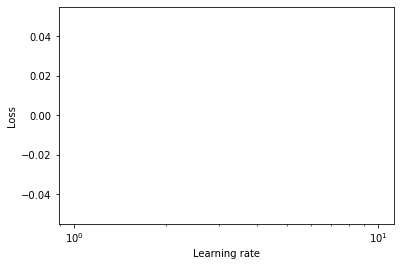

<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>

In [28]:
lr_finder.plot()

In [ ]:
min_loss = min(lr_finder.history['loss'])
lr_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR: ", lr_rate)

In [ ]:
#lr late is the max LR from lr_finder

In [ ]:
ocp_lr = 0.303 #steepest gradient

In [ ]:
cifar10_trainloader, cifar10_testloader = get_augmented_cifar10_dataset("/home/raghuc/work/data/", train_tfms=assn8_train_transforms, test_tfms=assn8_test_transforms, batch_sz=512, shuffle=False)

In [ ]:
optimizer = torch.optim.SGD(custom_resnet.parameters(), lr=lr_rate/10, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr_rate, steps_per_epoch=int(len(cifar10_trainloader)/512), epochs=24, pct_start=0.2, div_factor=10, three_phase=False, final_div_factor=50, anneal_strategy='linear')

In [ ]:
EPOCHS = 24

train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(custom_resnet, device, cifar10_trainloader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test(custom_resnet, device, cifar10_testloader, test_losses, test_acc)